<a href="https://colab.research.google.com/github/tatamiya/blog_artifacts/blob/main/zenn/20231216_spike_and_slab/Spike_and_Slab%E5%9B%9E%E5%B8%B0%E3%82%92PyMC%E3%81%A7%E8%A9%A6%E3%81%97%E3%81%A6%E3%81%BF%E3%82%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

以下の記事を参考に動かしてみる

http://www.batisengul.co.uk/post/spike-and-slab-bayesian-linear-regression-with-variable-selection/#:~:text=Spike%20and%20slab%20is%20a,from%20the%20regression%20towards%20zero

In [1]:
import pymc as pm
import numpy as np

import matplotlib.pyplot as plt
import arviz as az

In [2]:
pm.__version__

'5.7.2'

In [3]:
def get_model(y, X):
    model = pm.Model()
    Sigma = .5 * np.matmul(X.T, X)
    Sigma += np.diag(np.diag(Sigma))
    Sigma = np.linalg.inv(Sigma)
    with model:
        xi = pm.Bernoulli('xi', .5, shape=X.shape[1])
        tau = pm.HalfCauchy('tau', 1)
        sigma = pm.HalfNormal('sigma', 10)
        beta = pm.MvNormal('beta', 0, tau * Sigma, shape=X.shape[1])
        mean = pm.math.dot(X, xi * beta)
        y_obs = pm.Normal('y_obs', mean, sigma, observed=y)
    return model

In [4]:
x_min = 0.0
x_max = 8.0

x = x_min + (x_max - x_min) * np.arange(0, 21, 1) / 20
x

array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. , 4.4, 4.8,
       5.2, 5.6, 6. , 6.4, 6.8, 7.2, 7.6, 8. ])

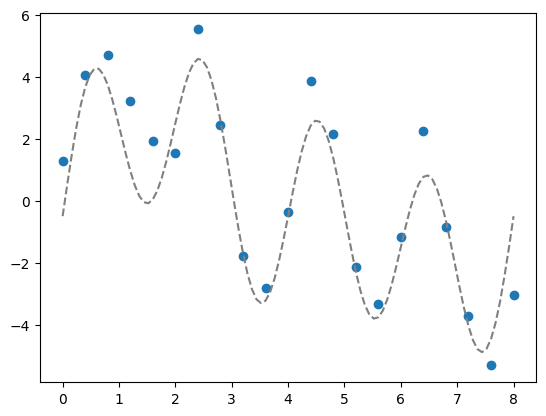

In [67]:
np.random.seed(0)

sigma = 1.0
sigma2 = sigma **2

#y = 0.5 * x**3 - 3.0 * x ** 2 +  4 * x + 3 + sigma * np.random.randn(x.shape[0])

#def target_func(x):
#  return 0.5 * x**3 - 2 * x ** 2 - 3

def target_func(x):
  return 2 * np.sin(2 * np.pi / 8 * x) + 1 * np.sin(2 * 2 * np.pi / 8 * x) - 0.5 * np.cos(2 * 2 * np.pi / 8 * x) + 3 * np.sin(4 * 2 * np.pi / 8 * x)

y =  target_func(x) + sigma * np.random.randn(x.shape[0])

x_sample = x_min + (x_max - x_min) * np.arange(0, 101, 1) / 100
y_org_sample = target_func(x_sample)

fig, ax = plt.subplots()
ax.plot(x_sample, y_org_sample, color="gray", linestyle="dashed")
ax.scatter(x, y)

In [6]:
x_des = np.array([np.sin(2 * np.pi / 8 * x), np.cos(2 * np.pi / 8 * x), np.sin(2 * 2 * np.pi / 8 * x), np.cos(2 * 2 * np.pi / 8 * x), np.sin(4 * 2 * np.pi / 8 * x), np.cos(4 * 2 * np.pi / 8 * x)]).T
#x_des = np.array([np.ones(x.shape[0]), x, x**2, x**3]).T

In [7]:
# 最小二乗法
np.linalg.inv(x_des.T @ x_des) @ x_des.T @ y

array([ 2.12320517, -0.03332416,  1.5313711 , -0.72545272,  3.16127397,
       -0.21130642])

In [8]:
model = get_model(y, x_des)

In [9]:
with model:
    # draw 1000 posterior samples
    idata = pm.sample()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


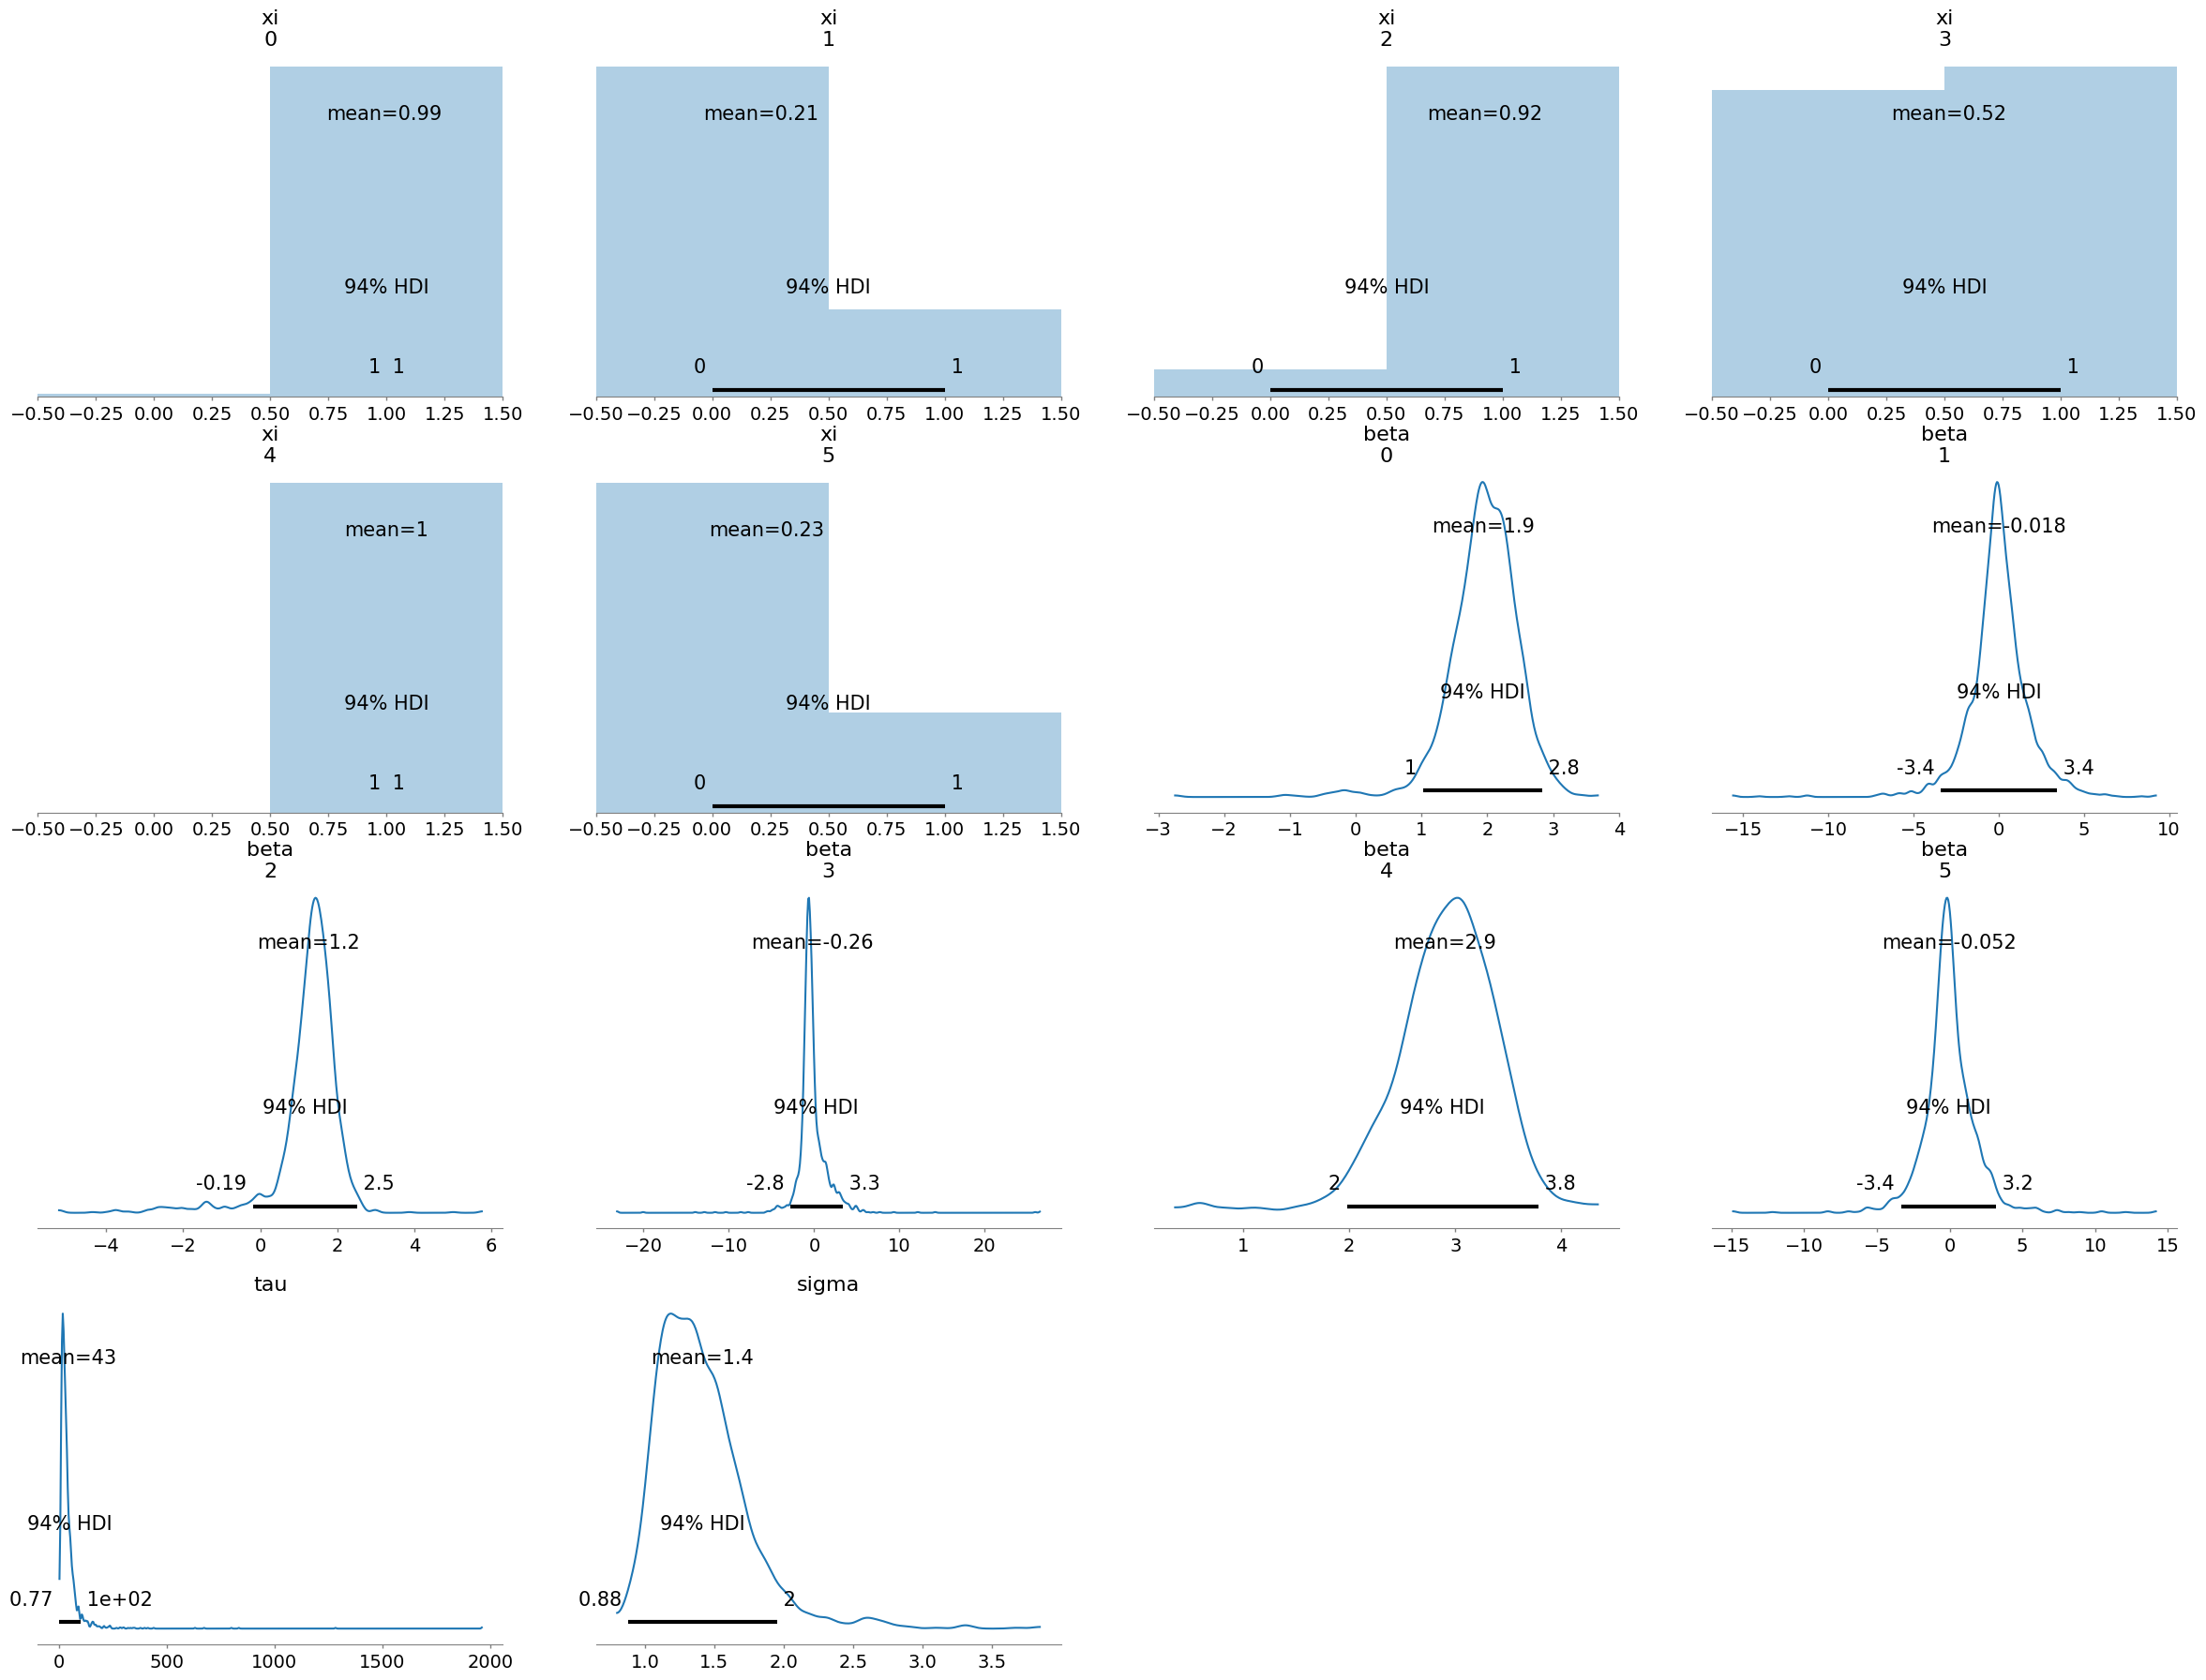

In [10]:
az.plot_posterior(idata, show=True);

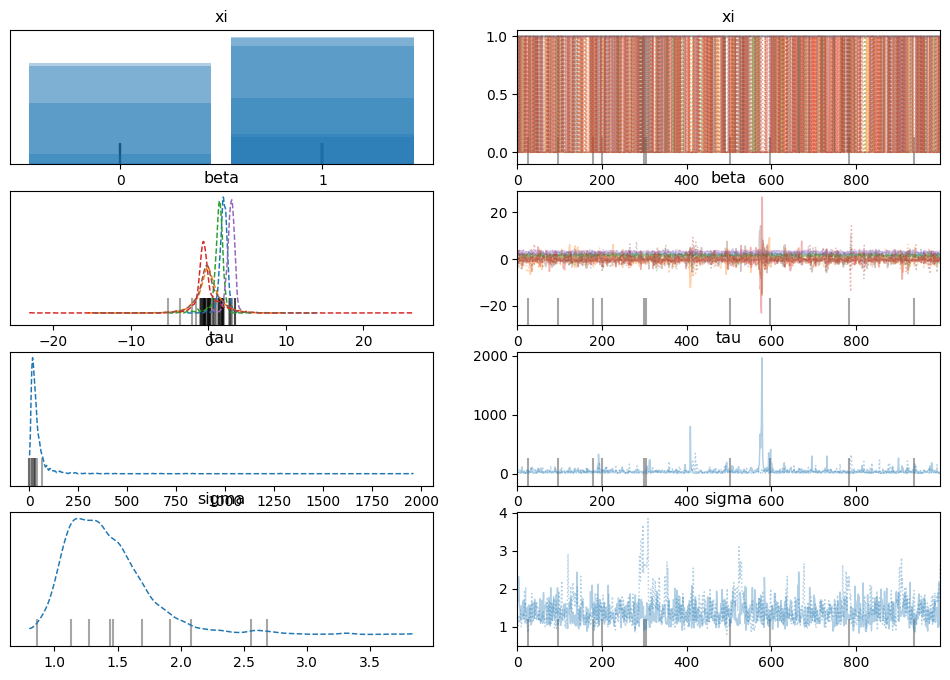

In [11]:
az.plot_trace(idata, combined=True);

In [12]:
az.summary(idata)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
xi[0],0.990,0.100,1.000,1.000,0.006,0.004,277.0,2000.0,1.00
xi[1],0.210,0.408,0.000,1.000,0.010,0.007,1583.0,1583.0,1.00
xi[2],0.922,0.268,0.000,1.000,0.025,0.018,111.0,111.0,1.04
xi[3],0.518,0.500,0.000,1.000,0.023,0.016,484.0,484.0,1.00
xi[4],0.999,0.032,1.000,1.000,0.001,0.000,2008.0,2000.0,1.00
xi[5],0.233,0.423,0.000,1.000,0.011,0.008,1409.0,1409.0,1.00
beta[0],1.943,0.526,1.023,2.839,0.026,0.019,787.0,303.0,1.01
beta[1],-0.018,1.808,-3.399,3.410,0.058,0.060,1125.0,751.0,1.00
beta[2],1.241,0.876,-0.186,2.513,0.070,0.050,304.0,125.0,1.02
beta[3],-0.263,1.966,-2.779,3.314,0.059,0.070,1069.0,759.0,1.00


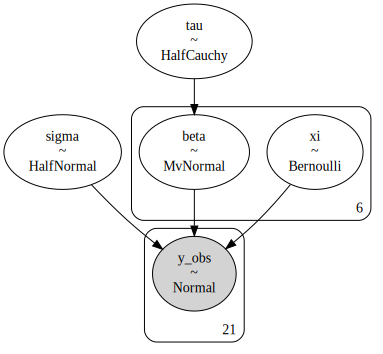

In [13]:
pm.model_to_graphviz(model)

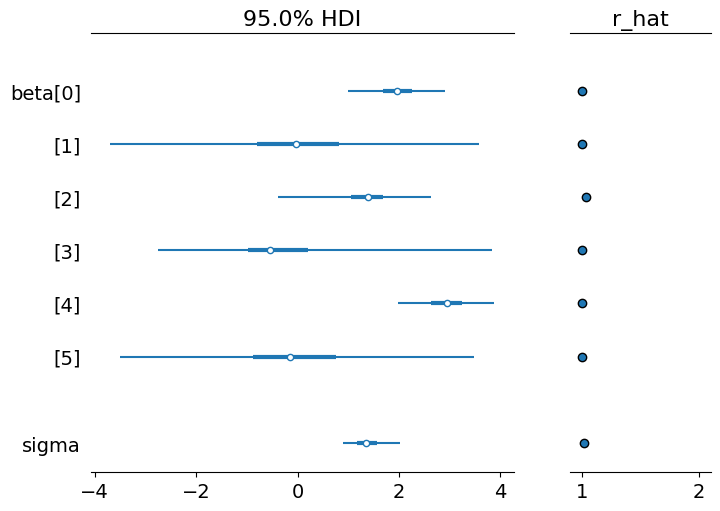

In [14]:
az.plot_forest(idata, var_names=["beta", "sigma"], combined=True, hdi_prob=0.95, r_hat=True);

In [15]:
x_sample_des = np.array([np.sin(2 * np.pi / 8 * x_sample), np.cos(2 * np.pi / 8 * x_sample), np.sin(2 * 2 * np.pi / 8 * x_sample), np.cos(2 * 2 * np.pi / 8 * x_sample), np.sin(4 * 2 * np.pi / 8 * x_sample), np.cos(4 * 2 * np.pi / 8 * x_sample)]).T

In [16]:
idata.posterior["xi"].to_numpy().shape

(2, 1000, 6)

In [17]:
idata.posterior["xi"].to_numpy().mean(1)

array([[0.999, 0.204, 0.985, 0.506, 1.   , 0.231],
       [0.981, 0.217, 0.859, 0.53 , 0.998, 0.235]])

In [18]:
(idata.posterior["beta"].to_numpy() * idata.posterior["xi"].to_numpy()).shape

(2, 1000, 6)

In [19]:
y_model = ((idata.posterior["beta"].to_numpy() * idata.posterior["xi"].to_numpy()) @ x_sample_des.T)

In [20]:
y_model.shape

(2, 1000, 101)

In [21]:
x_sample.repeat(2000).reshape(101,2000).T

array([[0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       ...,
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ]])

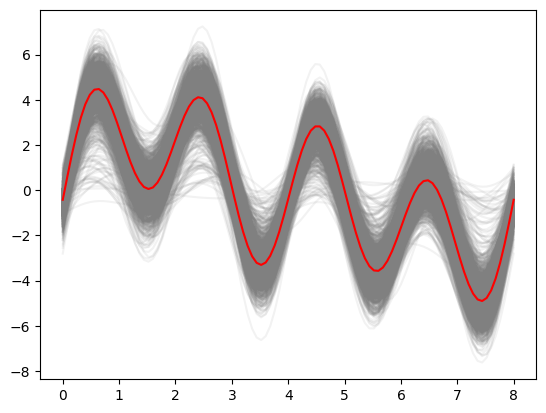

In [22]:
plt.plot(x_sample.repeat(2000).reshape(-1,2000), y_model.reshape(2000,-1).T, color="gray", alpha=0.1);
plt.plot(x_sample, y_model.reshape(2000, -1).mean(0), color="red");

In [23]:
y_lower, y_upper = np.percentile(y_model.reshape(2000,-1), q=[2.5,97.5], axis=0)

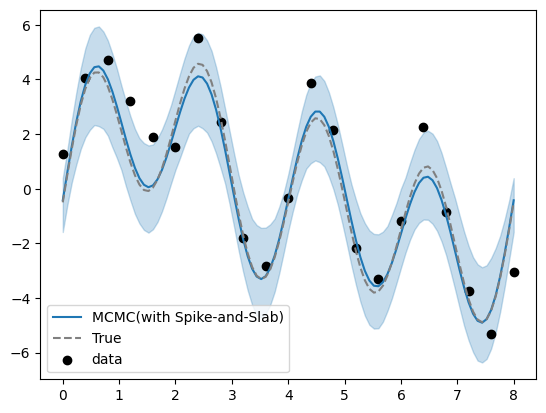

In [52]:
fig, ax = plt.subplots()

ax.plot(x_sample, y_model.reshape(2000, -1).mean(0), label="MCMC(with Spike-and-Slab)");
ax.plot(x_sample, y_org_sample, color="gray", linestyle="dashed", label="True")
ax.fill_between(x_sample, y_lower, y_upper, alpha=0.25, color='tab:blue')
ax.scatter(x, y, label="data", color="black")
ax.legend(loc="best")

# Spike-and-Slab 事前分布を用いないベイズ線形回帰モデル

In [25]:
def get_linear_model(y, X):
    model = pm.Model()
    Sigma = .5 * np.matmul(X.T, X)
    Sigma += np.diag(np.diag(Sigma))
    Sigma = np.linalg.inv(Sigma)
    with model:
        #xi = pm.Bernoulli('xi', .5, shape=X.shape[1])
        tau = pm.HalfCauchy('tau', 1)
        sigma = pm.HalfNormal('sigma', 10)
        beta = pm.MvNormal('beta', 0, tau * Sigma, shape=X.shape[1])
        #mean = pm.math.dot(X, xi * beta)
        mean = pm.math.dot(X, beta)
        y_obs = pm.Normal('y_obs', mean, sigma, observed=y)
    return model

In [26]:
linear_model = get_linear_model(y, x_des)

In [27]:
with linear_model:
    # draw 1000 posterior samples
    idata_linear = pm.sample()

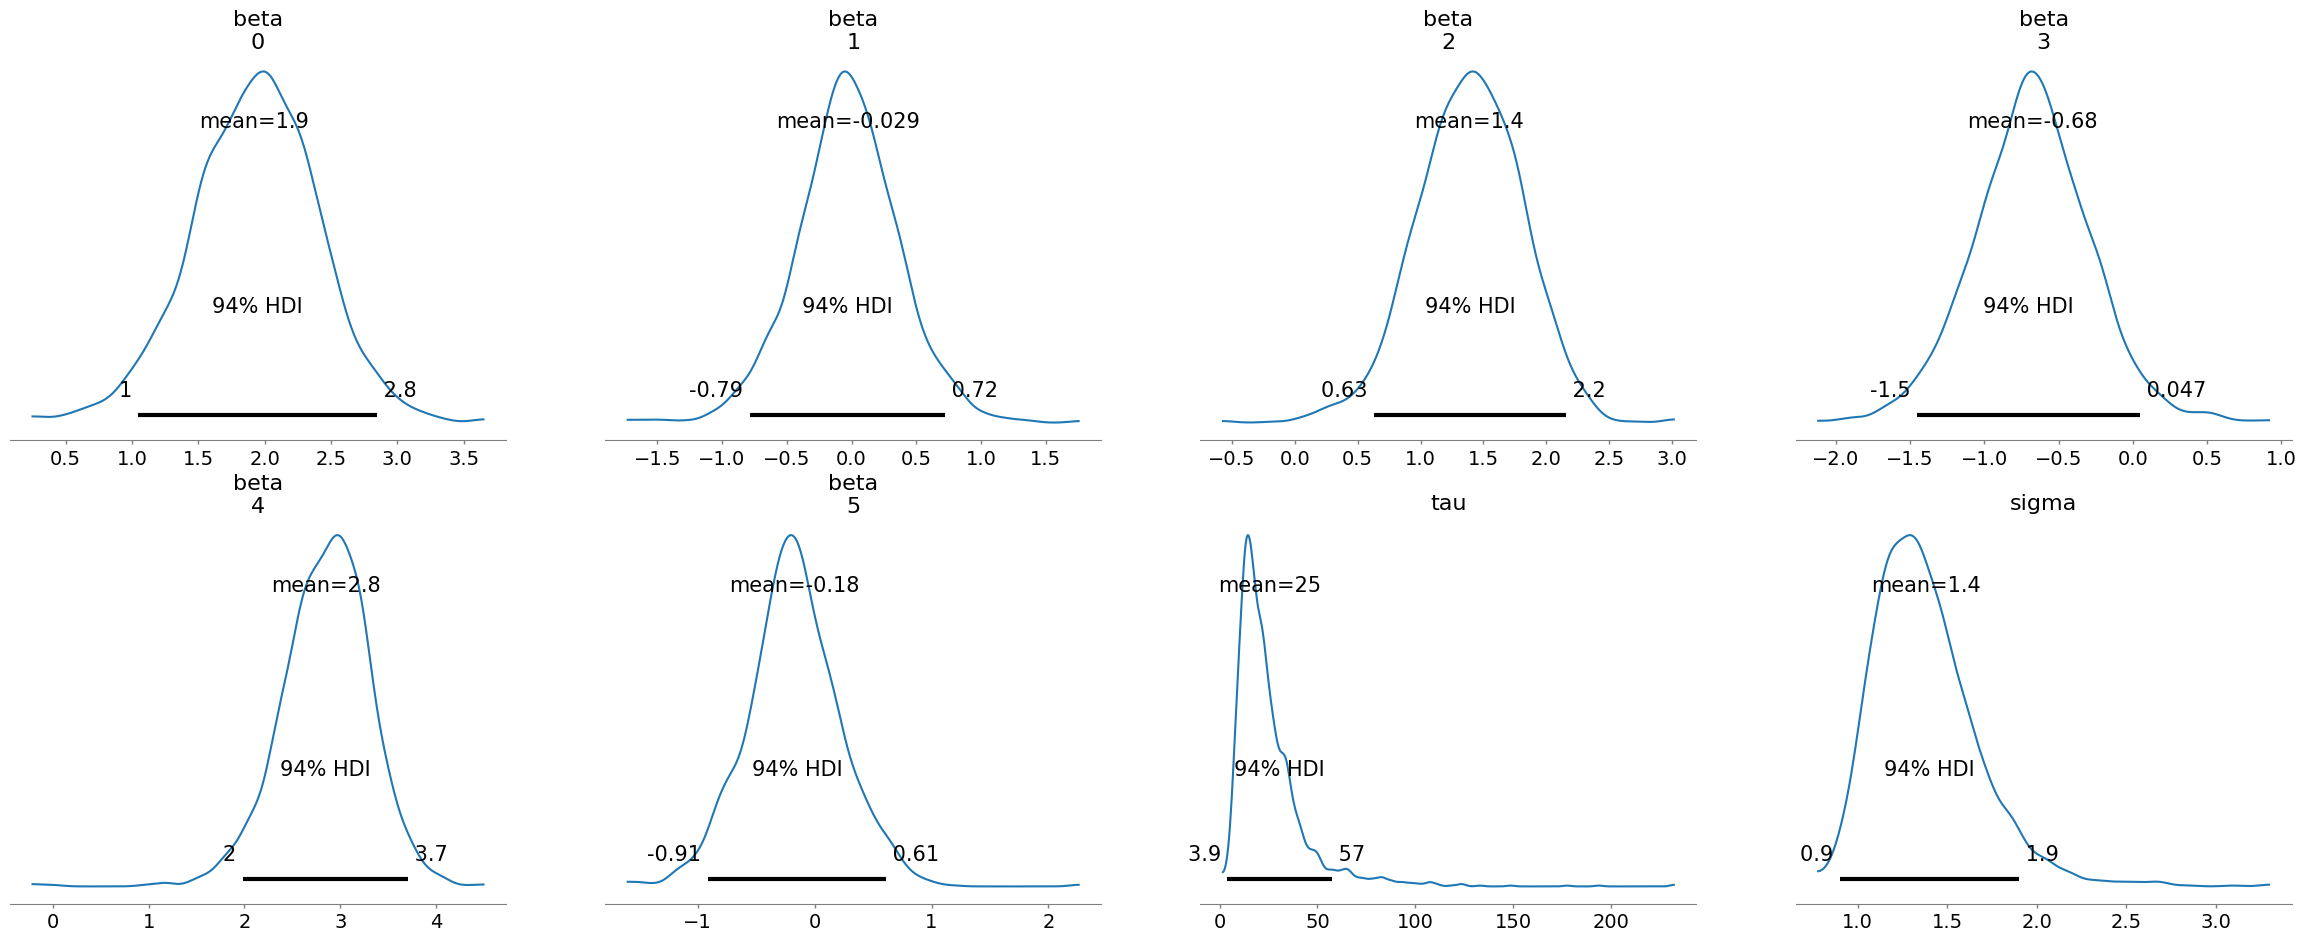

In [28]:
az.plot_posterior(idata_linear, show=True);

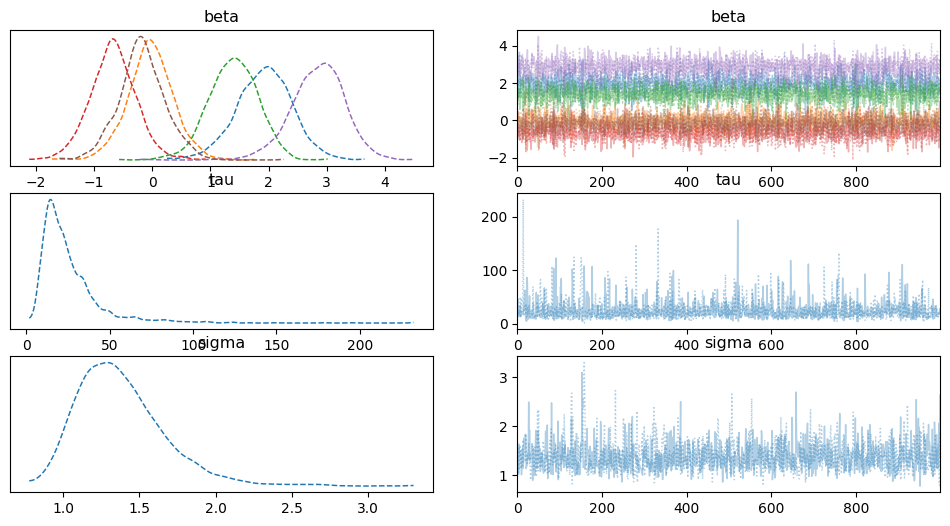

In [29]:
az.plot_trace(idata_linear, combined=True);

In [30]:
az.summary(idata_linear)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],1.923,0.475,1.049,2.848,0.011,0.007,2094.0,1393.0,1.0
beta[1],-0.029,0.398,-0.785,0.724,0.008,0.009,2328.0,1502.0,1.0
beta[2],1.388,0.418,0.629,2.161,0.008,0.006,2774.0,1756.0,1.0
beta[3],-0.675,0.396,-1.453,0.047,0.008,0.007,2262.0,1303.0,1.0
beta[4],2.848,0.469,1.980,3.707,0.011,0.008,1954.0,1294.0,1.0
beta[5],-0.178,0.400,-0.913,0.612,0.008,0.008,2515.0,1447.0,1.0
tau,25.448,18.703,3.943,57.321,0.464,0.332,1946.0,1399.0,1.0
sigma,1.382,0.294,0.901,1.902,0.009,0.006,1262.0,1434.0,1.0


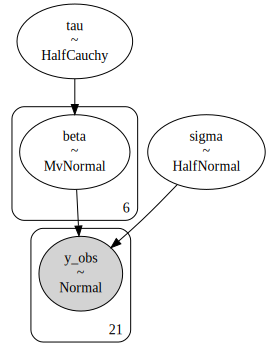

In [31]:
pm.model_to_graphviz(linear_model)

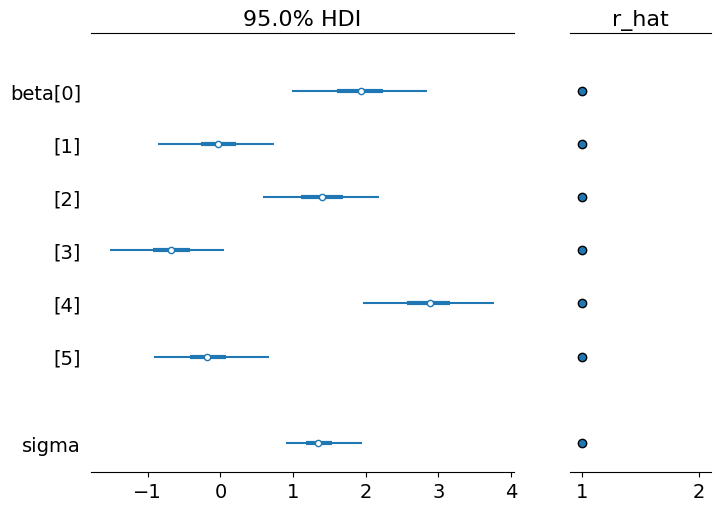

In [32]:
az.plot_forest(idata_linear, var_names=["beta", "sigma"], combined=True, hdi_prob=0.95, r_hat=True);

In [33]:
x_sample_des = np.array([np.sin(2 * np.pi / 8 * x_sample), np.cos(2 * np.pi / 8 * x_sample), np.sin(2 * 2 * np.pi / 8 * x_sample), np.cos(2 * 2 * np.pi / 8 * x_sample), np.sin(4 * 2 * np.pi / 8 * x_sample), np.cos(4 * 2 * np.pi / 8 * x_sample)]).T

In [34]:
y_linear_model = (idata.posterior["beta"].to_numpy() @ x_sample_des.T)

In [35]:
y_linear_model.shape

(2, 1000, 101)

In [36]:
x_sample.repeat(2000).reshape(101,2000).T

array([[0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       ...,
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ]])

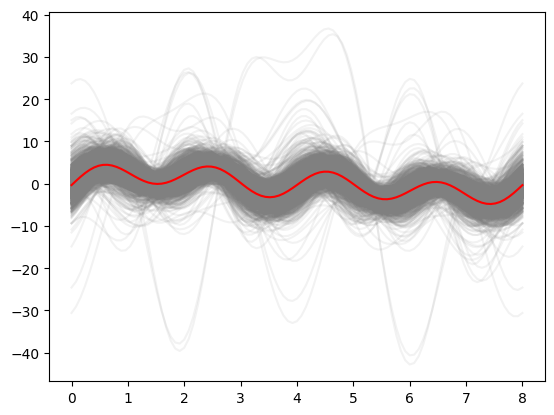

In [37]:
plt.plot(x_sample.repeat(2000).reshape(-1,2000), y_linear_model.reshape(2000,-1).T, color="gray", alpha=0.1);
plt.plot(x_sample, y_linear_model.reshape(2000, -1).mean(0), color="red");

In [38]:
y_lower_linear, y_upper_linear = np.percentile(y_linear_model.reshape(2000,-1), q=[2.5,97.5], axis=0)

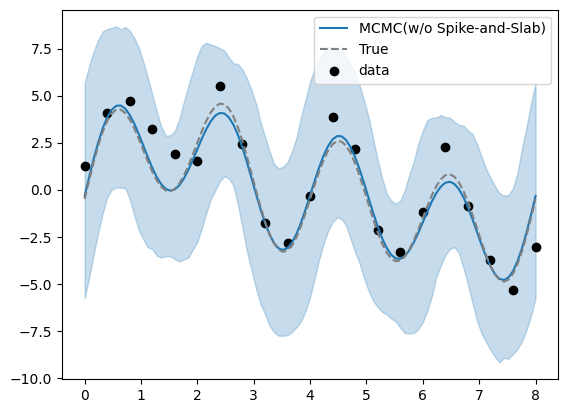

In [51]:
fig, ax = plt.subplots()

ax.plot(x_sample, y_linear_model.reshape(2000, -1).mean(0), label="MCMC(w/o Spike-and-Slab)");
ax.plot(x_sample, y_org_sample, color="gray", linestyle="dashed", label="True")
ax.fill_between(x_sample, y_lower_linear, y_upper_linear, alpha=0.25, color='tab:blue')
ax.scatter(x, y, label="data", color="black")
ax.legend(loc="best")

# ベイズを使わず最小二乗法でやってみる

In [40]:
import statsmodels.api as sm

In [41]:
sm.__version__

'0.14.1'

In [42]:
mod = sm.OLS(y, x_des)

In [43]:
res = mod.fit()

In [44]:
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.884
Model:                            OLS   Adj. R-squared (uncentered):              0.837
Method:                 Least Squares   F-statistic:                              19.01
Date:                Sun, 24 Dec 2023   Prob (F-statistic):                    3.18e-06
Time:                        03:35:00   Log-Likelihood:                         -30.769
No. Observations:                  21   AIC:                                      73.54
Df Residuals:                      15   BIC:                                      79.80
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

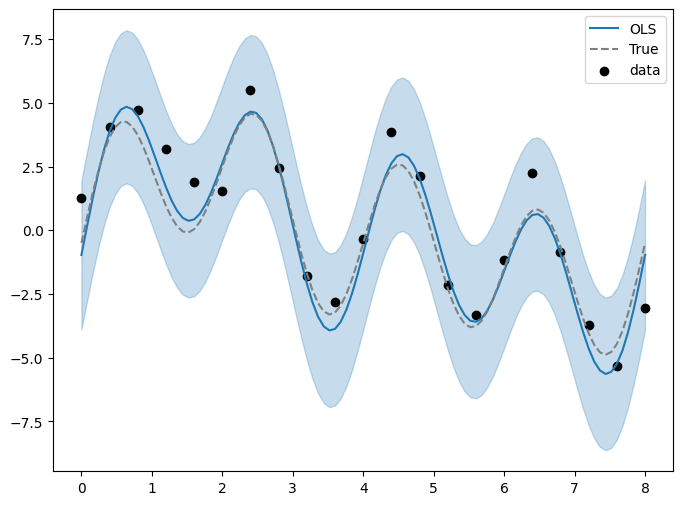

In [50]:
pred_ols = res.get_prediction(exog=x_sample_des)
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_sample, pred_ols.predicted, label="OLS");
ax.plot(x_sample, y_org_sample, color="gray", linestyle="dashed", label="True")
ax.fill_between(x_sample, iv_l, iv_u, alpha=0.25, color='tab:blue')
ax.scatter(x, y, label="data", color="black")
ax.legend(loc="best")

# 3つの結果を並べる

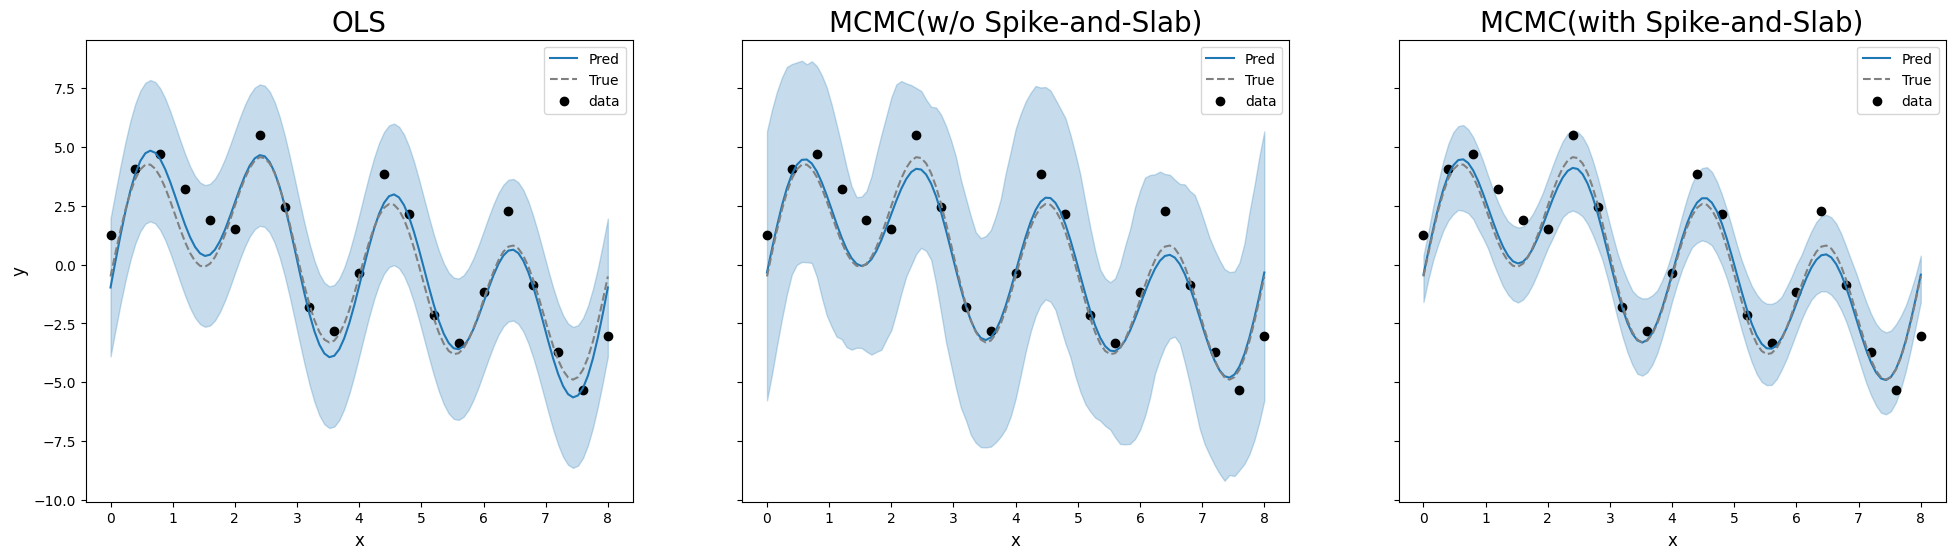

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(24,6))

ax0, ax1, ax2 = axes.flatten()

ax0.plot(x_sample, pred_ols.predicted, label="Pred");
ax0.plot(x_sample, y_org_sample, color="gray", linestyle="dashed", label="True")
ax0.fill_between(x_sample, iv_l, iv_u, alpha=0.25, color='tab:blue')
ax0.scatter(x, y, label="data", color="black")
ax0.set_title("OLS", fontsize=20)
ax0.set_xlabel("x", fontsize=12)
ax0.set_ylabel("y", fontsize=12)
ax0.legend(loc="best")

ax1.plot(x_sample, y_linear_model.reshape(2000, -1).mean(0), label="Pred");
ax1.plot(x_sample, y_org_sample, color="gray", linestyle="dashed", label="True")
ax1.fill_between(x_sample, y_lower_linear, y_upper_linear, alpha=0.25, color='tab:blue')
ax1.scatter(x, y, label="data", color="black")
ax1.set_title("MCMC(w/o Spike-and-Slab)", fontsize=20)
ax1.set_xlabel("x", fontsize=12)
ax1.legend(loc="best")

ax2.plot(x_sample, y_model.reshape(2000, -1).mean(0), label="Pred");
ax2.plot(x_sample, y_org_sample, color="gray", linestyle="dashed", label="True")
ax2.fill_between(x_sample, y_lower, y_upper, alpha=0.25, color='tab:blue')
ax2.scatter(x, y, label="data", color="black")
ax2.set_title("MCMC(with Spike-and-Slab)", fontsize=20)
ax2.set_xlabel("x", fontsize=12)
ax2.legend(loc="best")

